# Portfolio Optimization with Stock Price Prediction

## Executive Summary:
In the project, we aim to provide a forward-seeing tool to optimize investment allocation for a given portfolio by utilizing LSTM neural network to predict future stock price and use sharpe ratio maximization strategy to balance return requirement and risk aversion. In this model, we use a given selection of prices from several industries: Apple, General Motor, Starbucks and Tesla. They represent stocks in several well-operating industries for us to diversify some unsystematic risks. We use Yahoo Finance to pull their data in the past year to perform our modeling. In the portfolio optimization model, we use the monte-carlo method to generate random weight distribution for 4 stocks and calculate annualized return and standard deviation (volatility in finance) for each of the allocation the choose the maximum sharpe ratio out of them as investment strategy. In the prediction process, we use LSTM neural network to predict stock prices and got explained variance score of 0.99 (best is 1). Therefore combining these two models we can get multistage portfolio optimization strategies.

## Background
### Finance perspective:
We use closing prices of stocks to measure return. We use annulized return, volatility, and sharpe ratio for calculation. Here we used log daily return rather than arithmatic return, this is because they are not symmetric.
$$ \text{return} = ln(\frac{FV}{PV}) $$
$$ \text{standard deviation} = \sum w_i^2\sigma _i ^2 + 2\sum_{i\neq j}w_i w_j cov_{i,j}$$
$$ \text{sharpe ratio} = \frac{\text{return}}{\text{stdev}} $$

Sharpe ratio is to measure the return earned to volatility. It is a good measurement for investors to know how much excess return they are earning compared to the risk they take on the investment. If the ratio is smaller than 1, then the investment should be a bad decision as the risk grows faster than the return.

### Stakeholders and Needs:
#### Stakeholders
- Ammature investors seeking to adjust/ optimize their investment portfolio in stock market.
- Professional investors like mutual fund managers looking for some suggestions for in investment structure and even fund allocation.

#### Needs: 
- Easy operation: User do not need to tune the parameters by themselves.
- Reliability: It's real money.
- Availability : The results and suggestions should be easily understandable to users.

### Data Resource:
We pull historical stock data from Yahoo finance. In this model I chose 4 stocks:`Apple (APPL), General Motors (GM), Starbux (SBUX), Tesla (TSLA)` and used their `[High, Low, Open, Close, Volume, Adj Close, Trading Volumes]` in the past year (252 trading days) for both parts of the model.

For portfolio allocation optimization we used the closing price to measure daily return, volatility and the sharpe ratio. For closing price prediction we used all variables except for closing price as training features to predict closing price. Therefore the two models should be suitable for long-term investment and adjust the portfolio as multistage rather than quick selling operation in stock market.



Here is set of images of the closing prices in the past year of the four selected stocks.

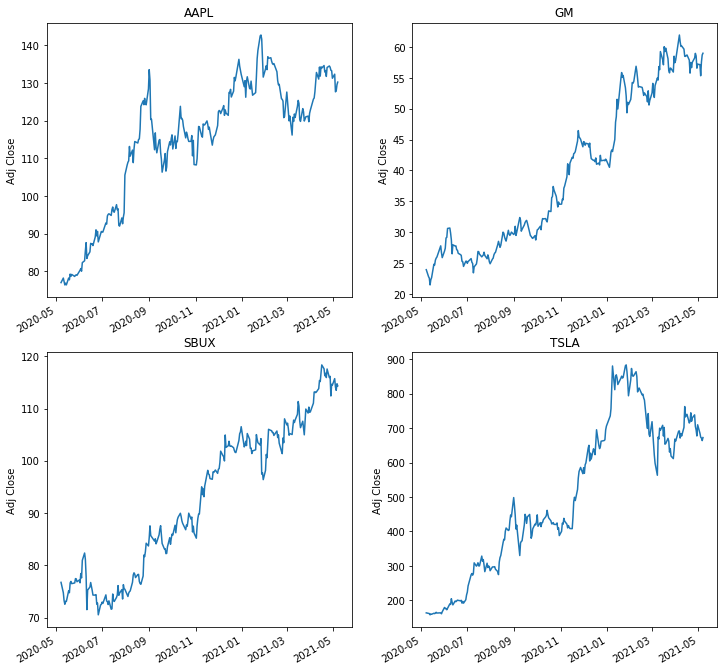

## Formulation
### Portfolio Allocation Optimization
#### Optimization Problem
- sr: sharpe ratio
- ret: daily log return
- w1,w2,w3,w4: allocation weights on the 4 stocks of choice
- vol/ stdev: volatility/ standard deviation on daily returns

$$ \text{maximize sr}=\frac{\text{return}}{\sigma _{ret}} $$
$$ \text{s.t.}$$
$$ w1+w2+w3+w4=1  $$
$$ 0\leq w1,w2,w3,w4 \leq 1 $$
$$\text{daily return}=ln(\frac{\text{closing price on that day}}{\text{closing price on Day 0}})$$ 
$$ \text{standard deviation} = \sum w_i^2\sigma _i ^2 + 2\sum_{i\neq j}w_i w_j cov_{i,j}$$
$$cov_{i,j} = \frac{corr(ret_i,ret_j)}{
  \sigma_{ret_i}\times\sigma_{ret_j}
}$$



#### Modeling Details
##### Data Exploration
- Histgram on daily returns

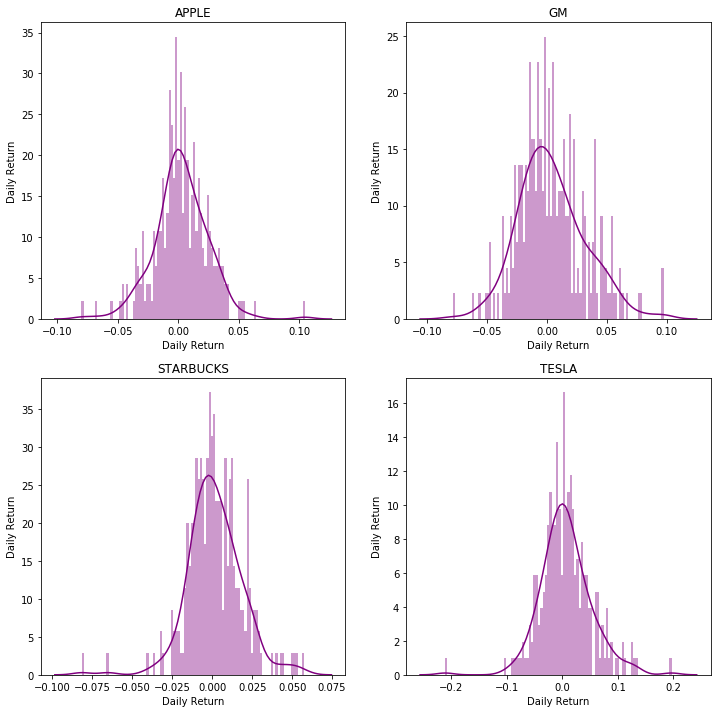

- Correlation of daily returns between different stocks
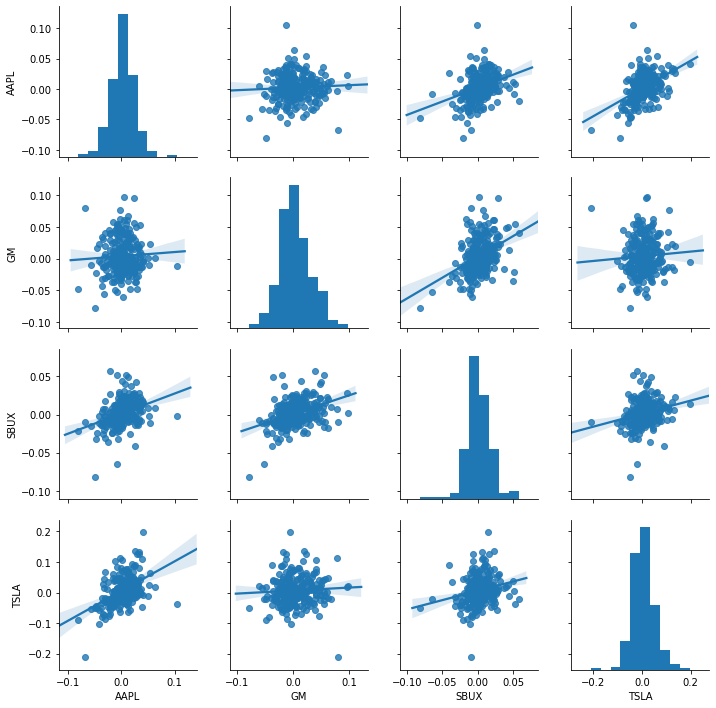

We can see that the 2 tech stocks - Apple and Tesla are the most correlated and it makes perfect sense.

#### Monte-Carlo Simulations on weights allocation generation

In [ ]:
md_random_weights = (
    gr.Model('weights')
    
    >>gr.cp_vec_function(
        fun = lambda df: gr.df_make(
        s = df.w1+df.w2+df.w3+df.w4
        ),
        var = ['w1','w2','w3','w4'],
        out = ['s']
    )
    

    >> gr.cp_marginals(
        w1={"dist": "uniform", "loc": 0, "scale": 1},
        w2={"dist": "uniform", "loc": 0, "scale": 1},
        w3={"dist": "uniform", "loc": 0, "scale": 1},
        w4={"dist": "uniform", "loc": 0, "scale": 1},
    )
    
    >> gr.cp_copula_independence()
)
md_random_weights.printpretty()

model: weights

  inputs:
    var_det:
    var_rand:
      w1: (+0) uniform, {'loc': 0, 'scale': 1}
      w2: (+0) uniform, {'loc': 0, 'scale': 1}
      w3: (+0) uniform, {'loc': 0, 'scale': 1}
      w4: (+0) uniform, {'loc': 0, 'scale': 1}
    copula:
        Independence copula
  functions:
    f0: ['w1', 'w2', 'w3', 'w4'] -> ['s']


We used uniform distribution for the 4 random weights because we need uniform distribution to equally explore the best weight allocation.

Then we perform a monte carlo simulation with `n=1e4` to generate 4 random numbers and then transform them into percentage where they sum to 1.

Then for each set of weights, we calculate the annualized return, standard deviation and then the sharpe ratio. Then we can choose the exact set of combination where the maximum sharpe ration is achieved. 

We can also find the efficient frontier of this portfolio during the monte carlo process. (The highest feasible expected returns in the same portfolio given different risk level.)


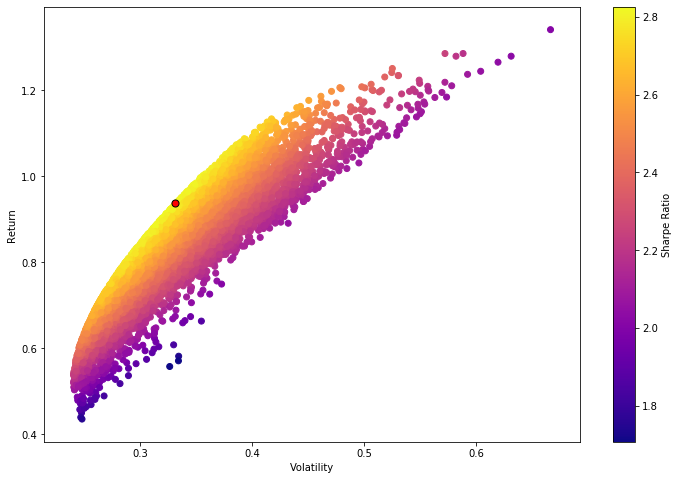

The red dot is the maximum sharpe ration point and the effient frontier is the curve on the left boarder. The best sr we could give in the past year is about 2.8 which is indeed pretty good. 

#### Model Validation
I used scipy minimize optimizer `SLSQP` with the same boundaries and got the same result.

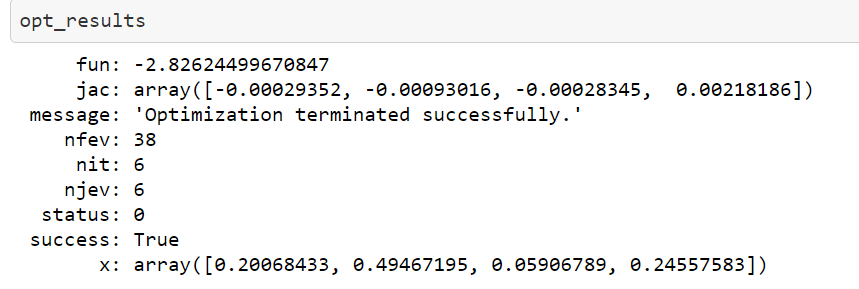

#### Limitations 
- This model cannot account for portfolios with more than 4 assets due to the way of construction.

### Results
We could see the plot from different allocations shown above and the final numerically best result. Technically there could be multiple maximum sharpe ratio on the effiecient frontier jand when that happens, our investor would have to decide between proportionally higher return and lower risk. As we all thought tech stocks especially like apple and tesla should perform better, to out surprise we should put (about) half of money in General Motors in the past year to achieve highest sharpe ration.

### Stock Price Prediction
The stock price prediction does not involve uncertainity modeling but serve as a tool for gaining insights on future stock price. Therefore we are going brief on this part. 
#### Optimization Problem
$$ \text{minimize MSE between predicted and true closing price} $$
There aren't really constraints as we are using neural network.

#### Modeling Details
- Feature Engineering/ Data Preprocessing <br>
As in the data exploration part, there are correlation between stock prices, therefore we are using one model for stock price prediction.
To teach the model to distinguish differest stocks, we first tranform company name into labelencoders. Then we use the first 7 months in the past year for training and the recent 3 months for testing. We use MinMaxScaler to transform all data into range 0-1.

- Neural Network<br>
    We used a one-layer LSTM with 50 unites and `adam` optimizer.

- Results <br>
We can see from the below figure that the prediction is quite accurate.
We also achieved explained_variance_score of 0.995 out of 1. 



<img src="sample.png">

- Limitations <br>
    - We could not utilize closing price from previous time due to the nature of neural network (the model could have learned to match closing price to the prediction only.)
    - Extra information of that day (High, low) is required for closing price prediction. For this part I should look more into financial knowledge to improve this part.


## Conclusions
We can see that both models perform pretty well using our measurements and takes relatively short time to run. 
The model can provide direct output to ammature investors who could not interpret complex information in financal market and with could show more for professional users like stock price prediction and efficient frontier for a given portfolio. The users do not need to tune parameters for models but just choose stocks of their choice (The flaw is that only 4-asset portfolios are supported at this moment. (Fewer is also possible by setting one column of df/weight to 0.)) But this potential improvement is mostly codewise, the construction of model should not be affected.

- What insights did you learn about designing for your chosen context and stakeholders? <br>
I learned that for my stakeholder, the output or say the presentation of suggestion is more important than the model itself because they do not care the math or code behind. Also, my model in this case is a little bit more about financial background rather than programming. But monte carlo simulation is indeed very useful in portfolio optimization for not just sharpe ration maximimization in this model. 

- What design decisions would I make? <br>
1. Interface interaction is better for users compared to typing in this model application. (I would like to change that.)
2. Multiple optimization techniques should also be available in the future given the current monte carlo simulation.
3. I would love to include multistage investment suggestion but would require different input from the user like selling point and maximum risk they are willing to take.

